# Sim-SOENs
## A Simulator for Superconducting Optoelectronic Networks

### Part 1: A Simple Neuron
 - Monosyptic neuron
   - betas
   - taus
   - biases
   - flux thresholds and rollover
   - thresholds and spiking
 - Exercise -> for same input, how to have three unique spiking results?

### Part 2: Dendritic Arbors
 - explain weights to arbor method
  - showcase structure plotting
  - Exercise -> build a 3x3 fractal neuron with SuperNode
 - Explain logic operations
   - showcase arbor activity plotting
   - Exercise -> invent an AND gate

### Part 3: Input-Output
 - input types and raster plots

### Part 4: Computing with A Single Neuron
 - Exercise -> invent a logic gate
 - Exercise -> solve 9-pixel problem


SOMA:
 ib = 1.802395858835221
 ib_n = 1.5523958588352207
 tau_ni = 50
 beta_ni = 628.3185307179587
 loops_present = ri
 s_th = 0.1


 ib_di = 1.802395858835221
 tau_di = 250
 beta_di = 628.3185307179587

REFRACTION:
 ib_ref = 1.7523958588352209
 tau_ref = 50
 beta_ref = 628.3185307179587

DENDRITES:
 soma rand_neuron_29695_soma
   ib_di = 1.5523958588352207
   tau_di = 50
   beta_di = 628.3185307179587
   loops_present = ri
   synaptic_inputs = []
   dendritic_inputs = ['rand_neuron_29695__dend_refraction', 'rand_neuron_29695_lay1_branch0_den0', 'rand_neuron_29695_lay1_branch0_den1', 'rand_neuron_29695_lay1_branch0_den2']
 refractory rand_neuron_29695__dend_refraction
   ib_di = 1.7523958588352209
   tau_di = 50
   beta_di = 628.3185307179587
   loops_present = ri
   synaptic_inputs = ['rand_neuron_29695__syn_refraction']
   dendritic_inputs = []
 arbor rand_neuron_29695_lay1_branch0_den0
   ib_di = 1.73
   tau_di = 10
   beta_di = 628.3185307179587
   loops_present = rtti
   synaptic

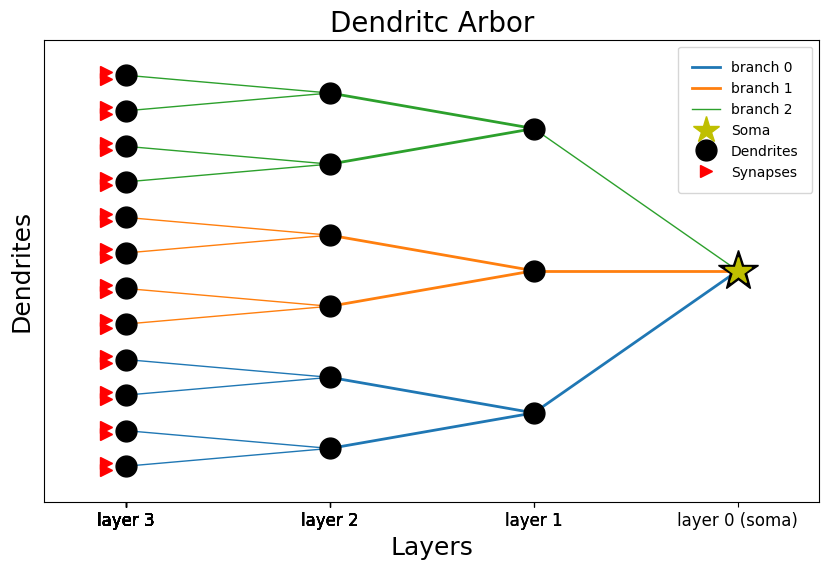

old way


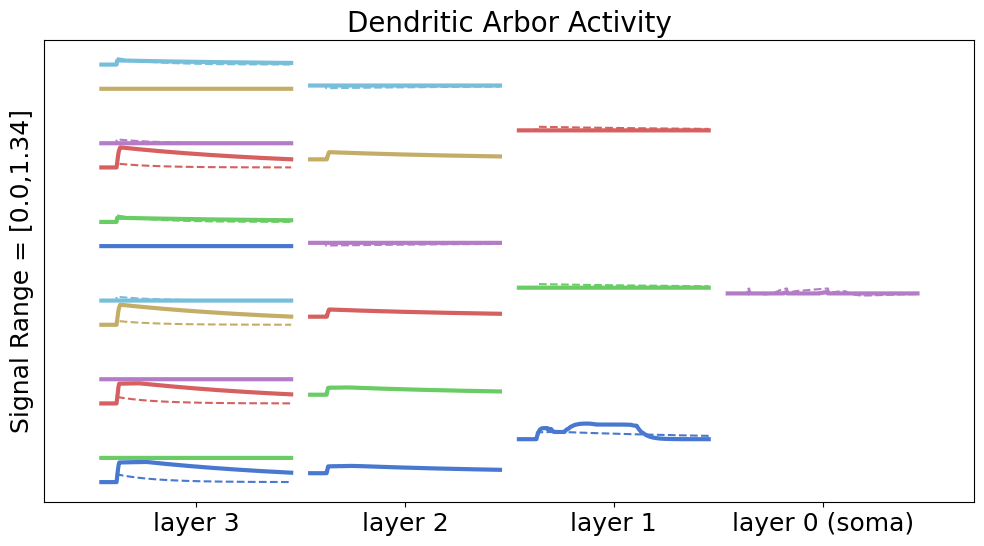

[array([0., 0., 0.]), array([ 28.2,  78. , 132. ])]
old way


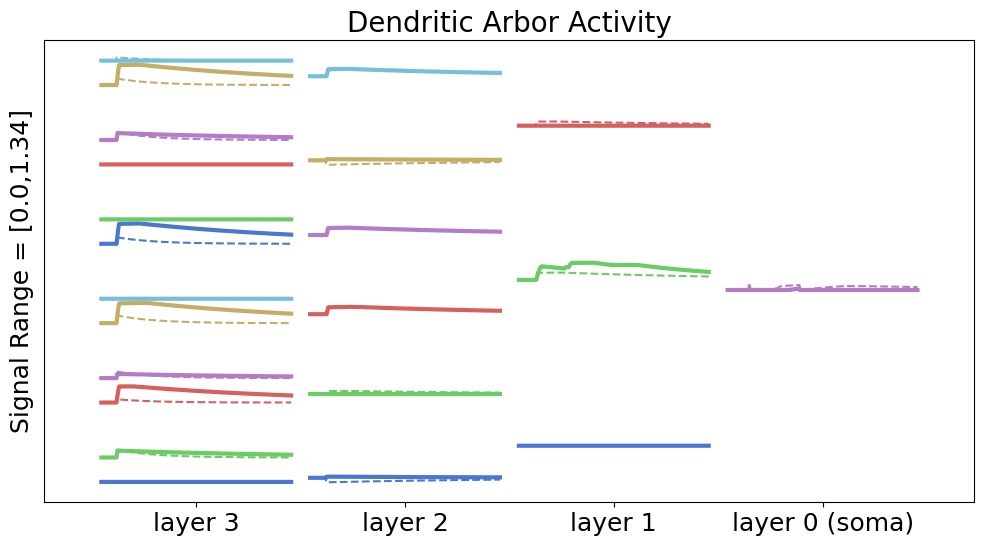

[array([0., 0.]), array([28.8, 94.5])]
old way


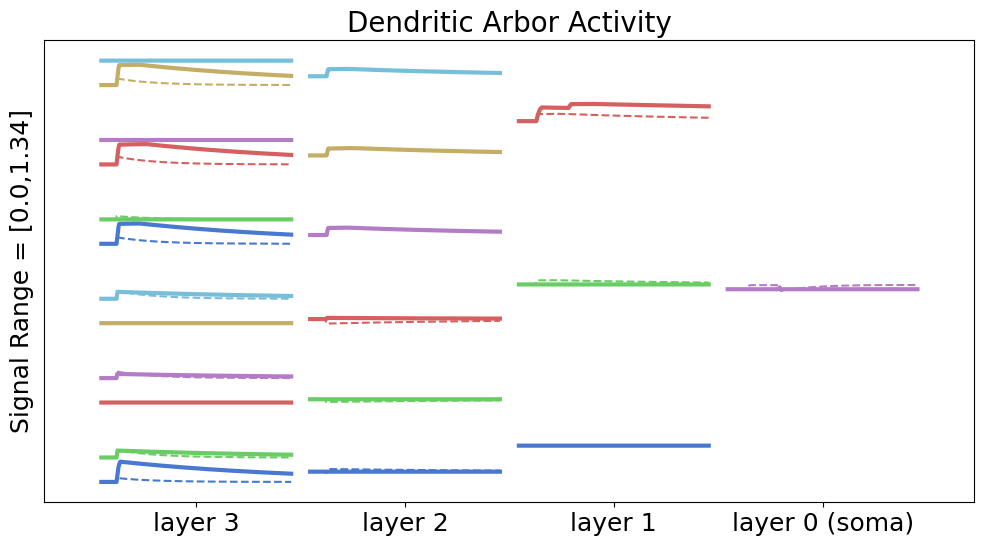

[array([0.]), array([68.6])]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# from super_library import NeuralZoo
from super_input import SuperInput
from soen_sim import network
from soen_plotting import activity_plot, arbor_activity, structure

from super_node import SuperNode
from soen_plotting import raster_plot

ib__list__ri = [1.3523958588352205, 1.4023958588352206, 1.4523958588352206, 
                1.5023958588352206, 1.5523958588352207, 1.6023958588352207, 
                1.6523958588352208, 1.7023958588352208, 1.7523958588352209, 
                1.802395858835221, 1.852395858835221, 1.902395858835221, 
                1.952395858835221, 2.002395858835221, 2.0523958588352214]

ib__list__rtti = [1.5, 1.57666667, 1.65333333, 1.73, 1.80666667, 1.88333333,
                1.96, 2.03666667, 2.11333333, 2.19, 2.26666667, 2.34333333,
                2.42,.49666667, 2.57333333, 2.65]

params = {
    'weights': [
        [[.5,.4,.3]],
        [[0.5,0.5],[0.5,0.5],[0.5,0.5]],
        [[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65]]
    ],
    'taus': [
        [[10,150,1000]],
        [[250,250],[250,250],[250,250]],
        [[250,250],[250,250],[250,250],[250,250],[250,250],[250,250]]
    ],

    'biases': [
        [[3,3,3]],
        [[5,5],[5,5],[5,5]],
        [[-4,3],[-4,3],[-4,3],[-4,3],[-4,3],[-4,3]]
    ],
    'types': [
        [['rtti','rtti','rtti']],
        [['ri','ri'],['ri','ri'],['ri','ri']],
        [['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri']]
    ],
    'syns': [['2','5'],['4','6'],['5','8'],['4','6'],['1','3'],['7','9'],
             ['4','6'],['2','5'],['7','9'],['1','3'],['4','6'],['5','8']],
    'syn_w': [[.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5],
              [.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5]],
       
    # "ib_ne": ib__list__ri[4],
    "tau_di": 250,
    "ib_n": ib__list__ri[4], 
    "beta_ni": 2*np.pi*1e2,
    "tau_ni": 50,
    "w_sd": 1,
    "ib_ref": ib__list__ri[8], 
    "beta_ref": 2*np.pi*1e2,
    "tau_ref": 50,
    'ib_list_ri':ib__list__ri[:],
    'ib_list_rtti':ib__list__rtti[:],
}

nine_neuron = SuperNode(s_th=.1,**params) 
nine_neuron.parameter_print()
nine_neuron.plot_structure()

z = np.array([0,1,4,7,8]) # z-pixel array
v = np.array([1,4,3,6,8])-1 # v
n = np.array([2,4,6,7,9])-1 # n
letters = [z,v,n]

for let in letters:

    indices = let
    times = np.ones(len(indices))*20
    def_spikes = [indices,times]
    input = SuperInput(channels=9, type='defined', defined_spikes=def_spikes, duration=100)
    # raster_plot(input.spike_arrays)
    count = 0
    for g in nine_neuron.synapses:
        for s in g:
            for i,row in enumerate(input.spike_rows):
                if i == int(s.name)-1:
                    s.add_input(input.signals[i])
                    count+=1

    net = network(sim=True,dt=.1,tf=250,nodes=[nine_neuron],new_way=False)

    nine_neuron.plot_arbor_activity(net,phir=True)
    # nine_neuron.plot_neuron_activity(net,legend=False,dend=False)
    print(net.spikes)
    # for i in range(3):
    #     plt.plot(net.t,nine_neuron.dendrites[1][0][i].phi_r,label=str(i))
    # plt.plot(net.t,nine_neuron.neuron.dend_soma.s,label='signal')
    # plt.plot(net.t,nine_neuron.neuron.dend_soma.phi_r,label='flux')
    # plt.legend()
    # plt.show()
    

### Part 5: Networking and Dynamics
 - Network demo with computation example!